In [1]:
%matplotlib inline

# Analyse your spatial data using sliding windows

This example shows how to use {func}`squidpy.tl.sliding_window` to divide the 
obs of an {attr}`anndata.AnnData` object into adjecent, potentially overlapping,
windows.

In [ ]:
import matplotlib.pyplot as plt

import squidpy as sq

First, let's download the MIBI-TOF dataset.

In [5]:
adata = sq.datasets.mibitof()

This data set contains a cell type annotation in {attr}`anndata.AnnData.obs["Cluster"]`
and a slide annotation in {attr}`anndata.AnnData.obs["library_id"]`

In [6]:
adata.obs

row_num  point  cell_id       X1  center_rowcoord  center_colcoord  \
3034-0      3086     23        2  60316.0            269.0              7.0   
3035-0      3087     23        3  60317.0            294.0              6.0   
3036-0      3088     23        4  60318.0            338.0              4.0   
3037-0      3089     23        6  60320.0            372.0              6.0   
3038-0      3090     23        8  60322.0            417.0              5.0   
...          ...    ...      ...      ...              ...              ...   
47342-2    48953     16     1103   2779.0            143.0           1016.0   
47343-2    48954     16     1104   2780.0            814.0           1017.0   
47344-2    48955     16     1105   2781.0            874.0           1018.0   
47345-2    48956     16     1106   2782.0            257.0           1019.0   
47346-2    48957     16     1107   2783.0            533.0           1019.0   

         cell_size   category donor        Cluster batch library_id  
3034-0       408.0  carcinoma  21d7     Epithelial     0    point23  
3035-0       408.0  carcinoma  21d7     Epithelial     0    point23  
3036-0       304.0  carcinoma  21d7      Imm_other     0    point23  
3037-0       219.0  carcinoma  21d7  Myeloid_CD11c     0    point23  
3038-0       303.0  carcinoma  21d7  Myeloid_CD11c     0    point23  
...            ...        ...   ...            ...   ...        ...  
47342-2      283.0  carcinoma  90de     Fibroblast     2    point16  
47343-2      147.0  carcinoma  90de     Fibroblast     2    point16  
47344-2      142.0  carcinoma  90de      Imm_other     2    point16  
47345-2      108.0  carcinoma  90de     Fibroblast     2    point16  
47346-2      111.0  carcinoma  90de     Fibroblast     2    point16  

[3309 rows x 12 columns]

Stratified by library, we now want to assign each cell to a sliding window of a given size.

In [7]:
sq.tl.sliding_window(
    adata=adata,
    library_key="library_id",  # to stratify by sample
    window_size=300,
    overlap=0,
    copy=False,  # we modify in place
)

Let's inspect the column that the function has added to our data.

In [8]:
adata.obs["sliding_window_assignment"]

3034-0      point23_window_0
3035-0      point23_window_0
3036-0      point23_window_1
3037-0      point23_window_1
3038-0      point23_window_1
                 ...        
47342-2    point16_window_12
47343-2    point16_window_14
47344-2    point16_window_14
47345-2    point16_window_12
47346-2    point16_window_13
Name: sliding_window_assignment, Length: 3309, dtype: category
Categories (48, object): ['point23_window_0' < 'point8_window_0' < 'point16_window_0' < 'point23_window_1' ... 'point16_window_14' < 'point23_window_15' < 'point8_window_15' < 'point16_window_15']

We see that each observation has been assigned to a window, which is defined by the `sliding_window_assignment` column. We can visualise this using {func}`squidpy.pl.spatial_scatter`.

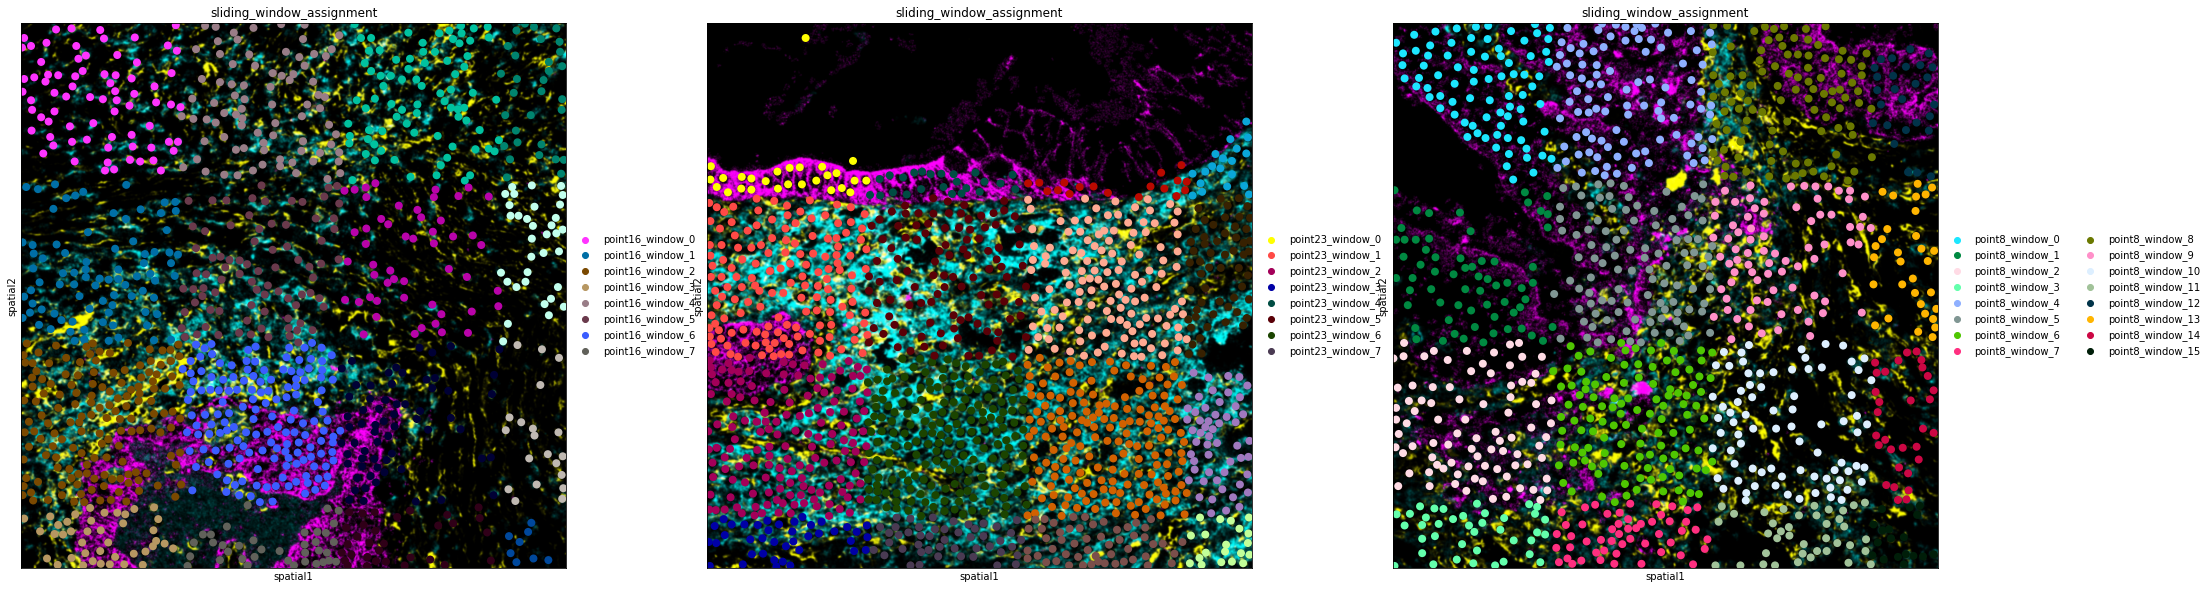

In [9]:
sq.pl.spatial_scatter(
    adata, color="sliding_window_assignment", library_key="library_id", figsize=(10, 10)
)

Optionally, we can also look at a specific sample:

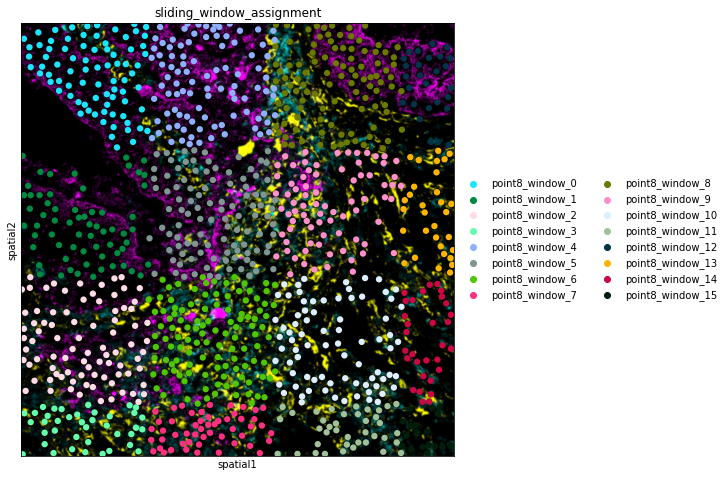

In [10]:
sq.pl.spatial_scatter(
    adata,
    color="sliding_window_assignment",
    library_key="library_id",
    library_id=["point8"],
    figsize=(10, 10),
)

We see that the function has created 16 windows, this is based on the `window_size` of 200 and an `overlap` of 0. The behaviour of the function changes when we use an overlap, since then observations will be assigned to multiple windows. This information can no longer be stored in a single column. Let's try this out.

In [11]:
adata = sq.datasets.mibitof()  # fresh copy

sq.tl.sliding_window(
    adata=adata,
    library_key="library_id",  # to stratify by sample
    window_size=300,
    overlap=50,
    copy=False,  # we modify in place
)

When now inspecting the {attr}`anndata.AnnData.obs`, we see that several columns have been added, each indicating whether an observation is a member of a specific window, stratified by `library_key`.

Due to the overlapping assignments, we now have more "true" assignments than observations. This is because each observation can be a member of multiple windows.

In [12]:
total_cells = 0
for lib_key in ["point8", "point16", "point23"]:
    cols_in_lib = adata.obs.columns[adata.obs.columns.str.contains(lib_key)]
    total_cells_in_lib = sum(adata.obs[col].sum() for col in cols_in_lib)
    total_cells += total_cells_in_lib
    print(f"Total cells in {lib_key}: {total_cells_in_lib}")

print(f"Total cells: {total_cells}")

Total cells in point8: 1421
Total cells in point16: 1421
Total cells in point23: 1727
Total cells: 4569


We can also illustrate these overlapping windows.

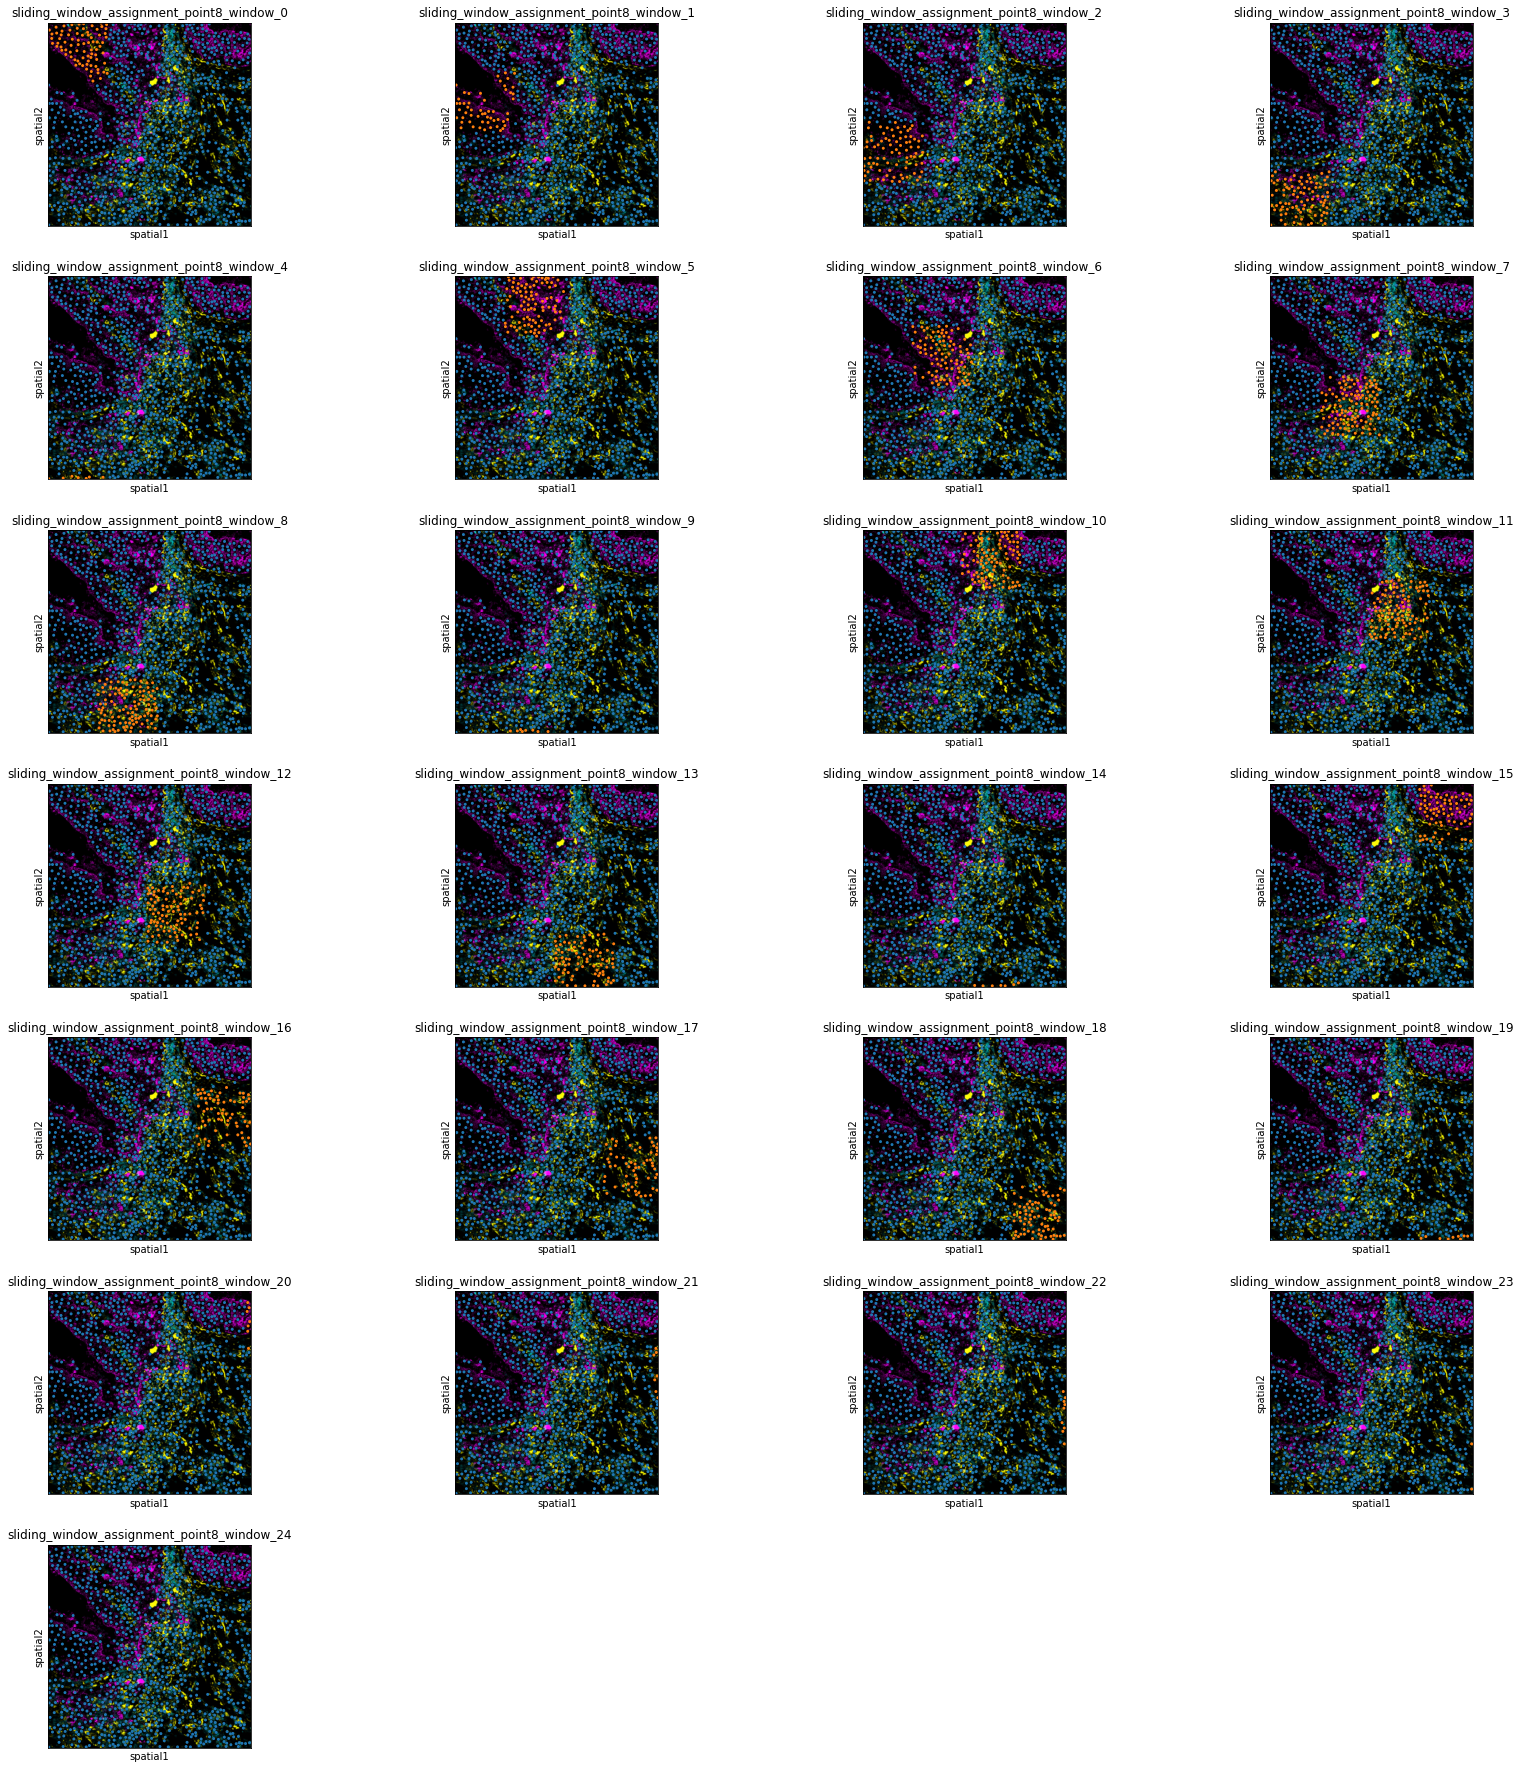

In [13]:
adata_point8 = adata[adata.obs["library_id"] == "point8"]
cols = adata.obs.columns[adata.obs.columns.str.contains("point8")]

# convert True/False to category so we can vizualize it
adata_point8.obs[cols] = adata_point8.obs[cols].astype("category")

sq.pl.spatial_scatter(
    adata_point8,
    color=cols,
    library_key="library_id",
    library_id="point8",
    legend_loc=None,
)
plt.tight_layout()

Finally, we see that these specific parameters result in tiny windows with very few cells at the bottom and right corner. We can drop these with the parameter `drop_partial_windows`. 

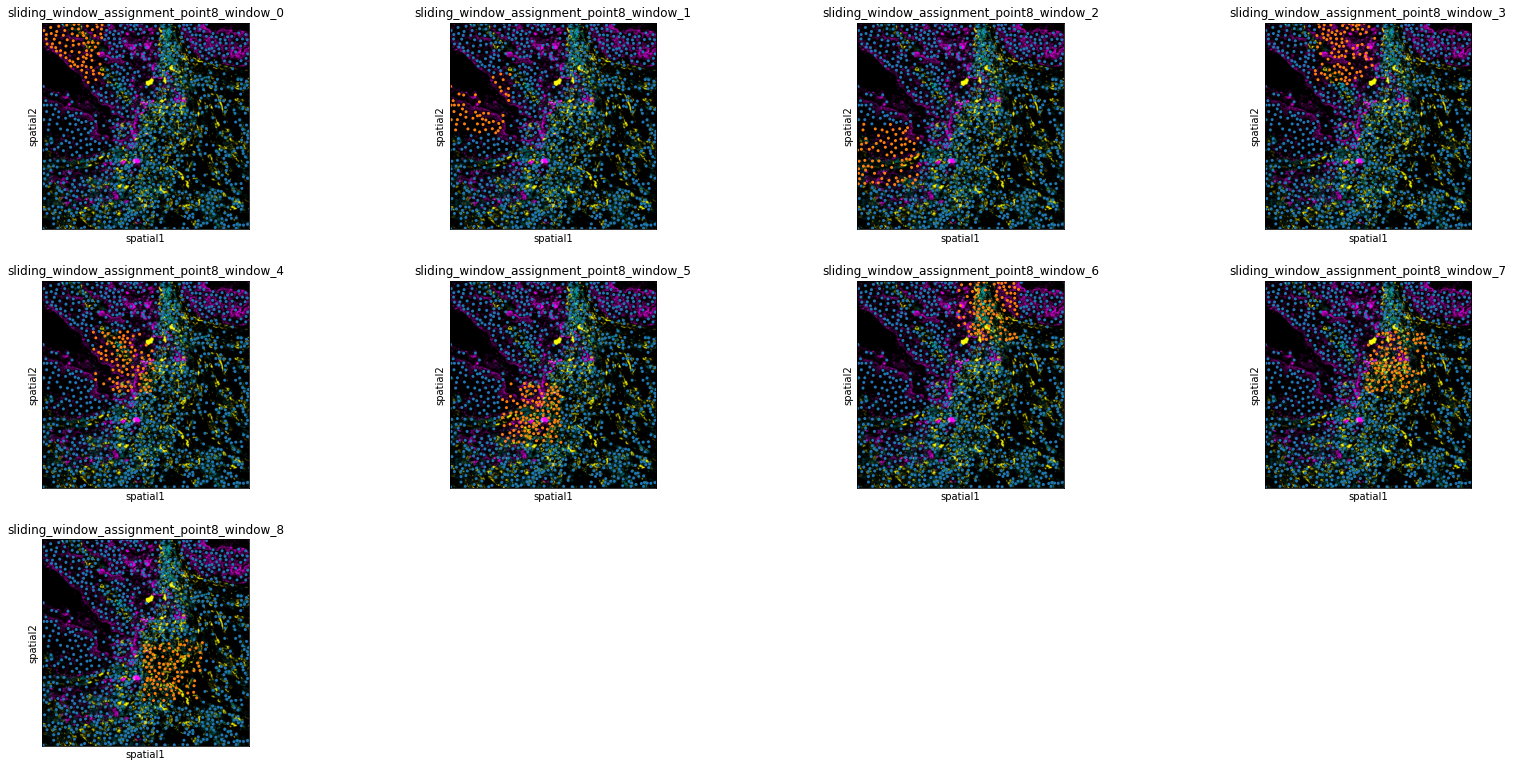

In [14]:
adata = sq.datasets.mibitof()  # fresh copy

sq.tl.sliding_window(
    adata=adata,
    library_key="library_id",  # to stratify by sample
    window_size=300,
    overlap=50,
    copy=False,  # we modify in place
    drop_partial_windows=True,
)

adata_point8 = adata[adata.obs["library_id"] == "point8"]
cols = adata.obs.columns[adata.obs.columns.str.contains("point8")]

# convert True/False to category so we can vizualize it
adata_point8.obs[cols] = adata_point8.obs[cols].astype("category")

sq.pl.spatial_scatter(
    adata_point8,
    color=cols,
    library_key="library_id",
    library_id="point8",
    legend_loc=None,
)
plt.tight_layout()

If desired, in-place modifications can be avoided by using `copy=True`. This then returns a {attr}`pandas.DataFrame` with the assignments.

In [15]:
adata = sq.datasets.mibitof()  # fresh copy

assignment = sq.tl.sliding_window(
    adata=adata,
    library_key="library_id",  # to stratify by sample
    window_size=300,
    overlap=50,
    copy=True,  # we modify in place
    drop_partial_windows=True,
)

assignment

sliding_window_assignment_point23_window_0  \
3034-0                                         True   
3035-0                                         True   
3036-0                                        False   
3037-0                                        False   
3038-0                                        False   
...                                             ...   
47342-2                                       False   
47343-2                                       False   
47344-2                                       False   
47345-2                                       False   
47346-2                                       False   

         sliding_window_assignment_point23_window_1  \
3034-0                                        False   
3035-0                                         True   
3036-0                                         True   
3037-0                                         True   
3038-0                                         True   
...                                             ...   
47342-2                                       False   
47343-2                                       False   
47344-2                                       False   
47345-2                                       False   
47346-2                                       False   

         sliding_window_assignment_point23_window_2  \
3034-0                                        False   
3035-0                                        False   
3036-0                                        False   
3037-0                                        False   
3038-0                                        False   
...                                             ...   
47342-2                                       False   
47343-2                                       False   
47344-2                                       False   
47345-2                                       False   
47346-2                                       False   

         sliding_window_assignment_point23_window_3  \
3034-0                                        False   
3035-0                                        False   
3036-0                                        False   
3037-0                                        False   
3038-0                                        False   
...                                             ...   
47342-2                                       False   
47343-2                                       False   
47344-2                                       False   
47345-2                                       False   
47346-2                                       False   

         sliding_window_assignment_point23_window_4  \
3034-0                                        False   
3035-0                                        False   
3036-0                                        False   
3037-0                                        False   
3038-0                                        False   
...                                             ...   
47342-2                                       False   
47343-2                                       False   
47344-2                                       False   
47345-2                                       False   
47346-2                                       False   

         sliding_window_assignment_point23_window_5  \
3034-0                                        False   
3035-0                                        False   
3036-0                                        False   
3037-0                                        False   
3038-0                                        False   
...                                             ...   
47342-2                                       False   
47343-2                                       False   
47344-2                                       False   
47345-2                                       False   
47346-2                                       False   

         sliding_window_assignment_point23_

### For reproducibility

In [16]:
import spatialdata

import numpy
import pandas

import matplotlib

import scanpy
import squidpy

%load_ext watermark

In [17]:
%watermark -v -m -p numpy,pandas,matplotlib,scanpy,squidpy,spatialdata

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.3.0

numpy      : 1.23.4
pandas     : 2.2.2
matplotlib : 3.9.2
scanpy     : 1.10.2
squidpy    : 1.6.2.dev34+gb4a49c9.d20241030
spatialdata: 0.2.2

Compiler    : Clang 15.0.7 
OS          : Darwin
Release     : 22.2.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

